In [24]:
import datetime as dt
import os, sys
import netCDF4 as nc
import matplotlib as mpl
import numpy as np
import numpy.ma as ma
from scipy.spatial import distance
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import cm
import matplotlib.colors as mpl_colors
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import matplotlib.mlab as mlab


from salishsea_tools import geo_tools, viz_tools

get_ipython().magic('matplotlib inline')

In [25]:
matplotlib.rcParams['font.size'] = 14

matplotlib.rcParams['axes.titlesize'] = 18

In [26]:
#Parameters

cmap = plt.get_cmap('nipy_spectral')
cmap.set_bad('burlywood')

H = 24 #One day in hours

#Ariane parameters
tunit= 3600

outint = 20 * 60 # 20 min in seconds

pph = int(tunit / outint) #points per hour

lmt = 1896 #points per particle

In [27]:
def plot(points, title = 'title', picname = "noname"):
    
    Iona = (-123.30898284912109, 49.187351226806641)
    S15 = (-123.3114, 49.130412)
    S16 = (-123.317415, 49.1214)
    xl=(-126.2,-122.2)
    yl=(47.1,51)




    #prepare plot and constants
    plt.clf()
    start = dt.datetime.now()
    print ("start: ", start)
    mesh = nc.Dataset("/ocean/gsgarbi/mesh_mask_downbyone2.nc")
    tmask=np.copy(mesh.variables['tmask'])
    mesh.close()
    fb=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/bathy_downonegrid2.nc')
    nav_lon=np.copy(fb.variables['nav_lon'])
    nav_lat=np.copy(fb.variables['nav_lat'])
    fb.close()
    
    lonlim=[np.min(nav_lon),np.max(nav_lon)]
    latlim=[np.min(nav_lat),np.max(nav_lat)]


    griddata=0.0*tmask[0,0,:,:]

    np.shape(points)[0]



    griddata, iedges, jedges = np.histogram2d(points[:,1],points[:,2],bins=[100,200],range=[lonlim,latlim])


    Jedges,Iedges=np.meshgrid(jedges,iedges)
    


    fig, axs = plt.subplots(1,1,figsize=(9,8))
    mesh0 = axs.pcolormesh(Iedges,Jedges,griddata,cmap=cmap)
    mesh0.set_clim(vmin = 0, vmax = 40)
    axs.set_xlim(xl)
    axs.set_ylim(yl)
    pos=axs.get_position()
    pos2=(pos.bounds[0],pos.bounds[1],pos.bounds[2]-.05,pos.bounds[3])
    axs.set_position(pos2)
    axs2 = plt.axes(pos2)
    viz_tools.set_aspect(axs,coords='map')
    mesh1=axs2.pcolormesh(nav_lon,nav_lat,np.ma.masked_where(tmask[0,0,:,:]==1,tmask[0,0,:,:]),cmap='YlOrRd')
    axs2.set_xlim(xl)
    axs2.set_ylim(yl)
    axs2.patch.set_alpha(0)
    viz_tools.set_aspect(axs2,coords='map')
    axsCB=plt.axes((pos2[0]+pos2[3],pos2[1],.02,pos2[3]))
    cbar = fig.colorbar(mesh0,cax=axsCB)
    cbar.set_label ("Counts")
    
    axs.set_title(title)

    
    plt.savefig(picname)
    
    print ("We have a total of {} trajectories".format(np.sum(griddata)))

In [28]:
def separate(nday):
    year1 = []
    year2 = []
    year3 = []

    for file in dirs:
        month = np.load(open(filesdir + file + "_{}d.npy".format(nday) , 'rb'))
        year1 += month [0::3]
        year2 += month [1::3]
        year3 += month [2::3]
        
    return (year1, year2, year3)




In [29]:
def plot_hist (pts, nday, init_depth):
    
    
    npyear=np.array(pts)

    df=pd.DataFrame(data=npyear[:,1:],index=npyear[:,0],columns=['Lon','Lat','Z','tind'])

    df2=df[(df.Lat>49.1) & (df.Lat<49.35)]
    
    fig, axs = plt.subplots(1,1,figsize=(9,8))

    axs.hist(df2['Z'],50,orientation='horizontal')
    
    
    
    plt.xlabel('Count')
    plt.ylabel('Depth (m)')
    
    title = ("Length of trajectory: {} days\n"
                    "Initial depth: {}m".format(nday, init_depth))
    
    plt.title ( title )
    
    plt.savefig( "/ocean/gsgarbi/analysis-giorgio/2017apr20_presentation/hist_{}d_{}m".format(nday, init_depth) )

In [30]:
def plot_hist_together (pts1, pts2, pts3, nday, init_depth):
    
    fig, axs = plt.subplots(1,1,figsize=(9,8))
    
    colors = ['lightblue', 'salmon', 'yellow']
    
    labels = ["45m", "59m", "77m"]
    
    idepth = [45, 59, 77]
    
    ls = ['dashed', 'dotted', None]
    
    fc = [(0, 0, 1, 0.5), (1, 0, 0, 0.5), (0, 0, 0, 0.5)]
    
    bin_num = 50
    
#     alphas = [0.2, 0.4, 0.8]
    
    for i, pts in enumerate([pts1, pts2, pts3]):
        npyear=np.array(pts)

        df=pd.DataFrame(data=npyear[:,1:],index=npyear[:,0],columns=['Lon','Lat','Z','tind'])

        df2=df[(df.Lat>49.1) & (df.Lat<49.35)]
        
        

        axs.hist(df2['Z'], bin_num, ls=ls[i], lw=3, fc=fc[i], orientation = 'horizontal')
        

        plt.xlabel('Count')
        plt.ylabel('Depth (m)')
    
    title = ("Length of trajectory: {} days\n"
                    "Initial depth: {}m".format(nday, init_depth))
    
    plt.title ( title )
    
    plt.savefig( "/ocean/gsgarbi/analysis-giorgio/2017apr20_presentation/hist_{}d_{}m".format(nday, init_depth) )

In [31]:
def alt_plot (pts1, pts2, pts3, nday, init_depth):
#     bins = numpy.linspace(-10, 10, 100)

    print ('start')
    

# plt.style.use('seaborn-deep')

#     x = np.random.normal(1, 2, 5000)
#     y = np.random.normal(-1, 3, 5000)
#     data = np.vstack([x, y]).T
#     bins = np.linspace(-10, 10, 30)

#     plt.hist(data, bins, alpha=0.7, label=['x', 'y'])
#     plt.legend(loc='upper right')
#     plt.show()


    
    colors = ['lightblue', 'salmon', 'yellow']
    
    labels = ["45m", "59m", "77m"]
    
    idepth = [45, 59, 77]
    
    ls = ['dashed', 'dotted', None]
    
    fc = [(0, 0, 1, 0.5), (1, 0, 0, 0.5), (0, 0, 0, 0.5)]
    
    bin_num = 50
    
    bins =[-400, 0, 50]
    
#     alphas = [0.2, 0.4, 0.8]

    arraylist = []
    
    for i, pts in enumerate([pts1, pts2, pts3]):
        
        print ('check1')
        
        print (len(pts))
        npyear=np.array(pts)

        df=pd.DataFrame(data=npyear[:,1:],index=npyear[:,0],columns=['Lon','Lat','Z','tind'])

        df2=df[(df.Lat>49.1) & (df.Lat<49.35)] # when we do this we get different shapes 
        

        
        
        arraylist.append(df2['Z'])
        
                
        print (np.shape(df2['Z']))
        
        print ('check2')


    outarr=np.ones((np.max([len(ps) for ps in arraylist]),len(arraylist)))*np.nan #define empty array
    for i,c in enumerate(arraylist):  #populate columns
        outarr[:len(c),i]=c
        
    print (np.shape(outarr))
        
        
        

    plt.hist(outarr, bin_num, alpha=0.5, label=labels, orientation="horizontal")
        


    print ('check3')
        
    plt.legend(loc='lower right')    
    plt.xlabel('Count')
    plt.ylabel('Depth (m)')
        
    
    title = ("Length of trajectory: {} days\n"
                    "Initial depths(m): {}".format(nday, init_depth))
    
    plt.title ( title )
    
    plt.tight_layout()

    plt.savefig("/ocean/gsgarbi/MEOPAR/private-docs/reports/IonaProject/ionafigs/{}d_alldepths.png".format(nday))

In [62]:
def create_array(filesdir, nday):
    
    dirs = os.listdir(filesdir)
    


    dirs.sort()

    pts = []

    for i in dirs:

        if str(nday)+"d" in i: #select length



            array = np.load(open(filesdir + i, 'rb'))

            pts.append(array)

    pts = np.array([i for sublist in pts for i in sublist])

    
    return pts

start
check1
42479
(18682,)
check2
check1
42479
(19548,)
check2
check1
42478
(20296,)
check2
(20296, 3)
check3


/ocean/gsgarbi/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/ocean/gsgarbi/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


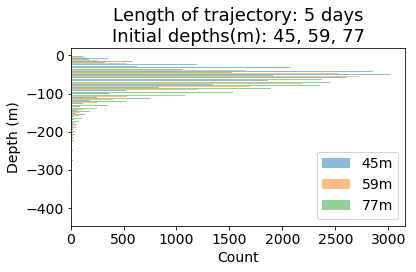

start
check1
8496
(4971,)
check2
check1
8496
(5078,)
check2
check1
8496
(5492,)
check2
(5492, 3)
check3


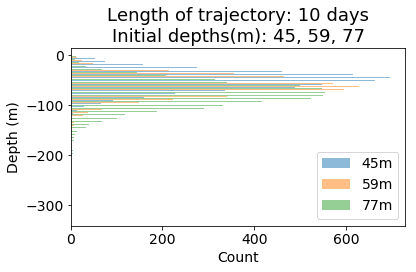

start
check1
8496
(3881,)
check2
check1
8496
(4079,)
check2
check1
8495
(4404,)
check2
(4404, 3)
check3


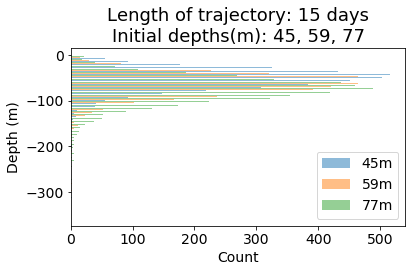

start
check1
8496
(3353,)
check2
check1
8496
(3543,)
check2
check1
8495
(3747,)
check2
(3747, 3)
check3


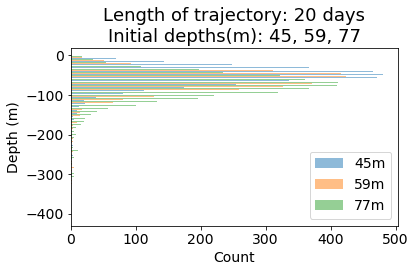

start
check1
8496
(3143,)
check2
check1
8496
(3267,)
check2
check1
8495
(3421,)
check2
(3421, 3)
check3


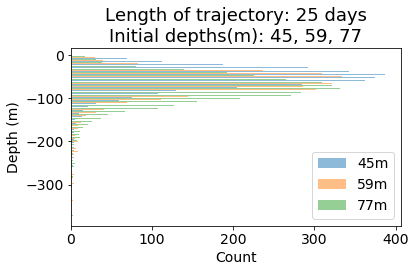

start
check1
8496
(2878,)
check2
check1
8496
(3061,)
check2
check1
8495
(3102,)
check2
(3102, 3)
check3


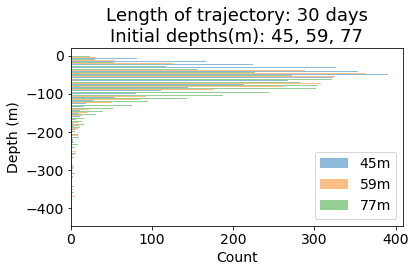

start
check1
8496
(2650,)
check2
check1
8496
(2803,)
check2
check1
8495
(2923,)
check2
(2923, 3)
check3


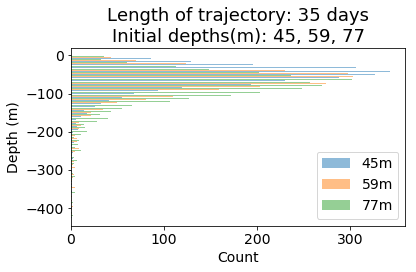

start
check1
8496
(2485,)
check2
check1
8496
(2625,)
check2
check1
8495
(2702,)
check2
(2702, 3)
check3


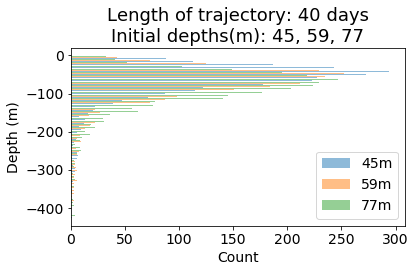

start
check1
8496
(2393,)
check2
check1
8496
(2482,)
check2
check1
8495
(2625,)
check2
(2625, 3)
check3


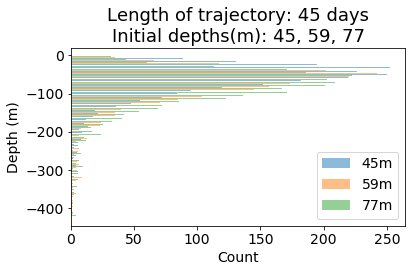

start
check1
9216
(2385,)
check2
check1
9216
(2613,)
check2
check1
9215
(2668,)
check2
(2668, 3)
check3


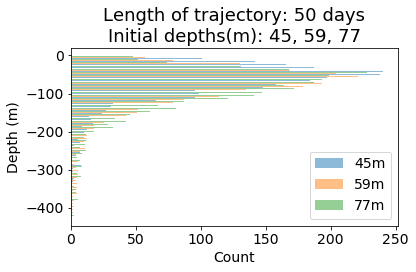

start
check1
9216
(1911,)
check2
check1
9215
(2039,)
check2
check1
9215
(1808,)
check2
(2039, 3)
check3


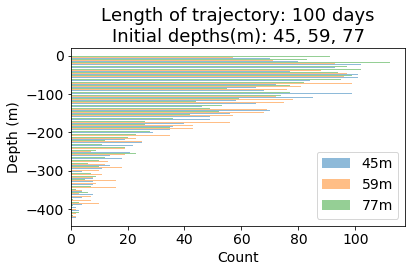

In [72]:
for nday in range (5,51,5):

    array = create_array("/ocean/gsgarbi/selected_days/", nday)

    year1 = array[0::3]
    year2 = array[1::3]
    year3 = array[2::3]

    init_depth = "45, 59, 77"
    alt_plot(pts1 = year1, pts2 = year2, pts3 = year3, nday = nday, init_depth = init_depth)
    
    plt.show()
    

nday = 100

array = create_array("/ocean/gsgarbi/selected_days/", nday)

year1 = array[0::3]
year2 = array[1::3]
year3 = array[2::3]

init_depth = "45, 59, 77"
alt_plot(pts1 = year1, pts2 = year2, pts3 = year3, nday = nday, init_depth = init_depth)

plt.show()

In [42]:
array_hind = create_array("/ocean/gsgarbi/selected_days/hindcast/", 10)
array_now = create_array("/ocean/gsgarbi/selected_days/", 10)

array_hind == array_now

20160101_20160131_10d.npy
20160201_20160229_10d.npy
20160301_20160331_10d.npy
20160401_20160430_10d.npy
20160501_20160531_10d.npy
20160601_20160630_10d.npy
20160701_20160731_10d.npy
20160801_20160831_10d.npy
20160901_20160930_10d.npy
20161001_20161031_10d.npy
20161101_20161130_10d.npy
20161201_20161231_10d.npy
25488
20160101_20160131_10d.npy
20160201_20160229_10d.npy
20160301_20160331_10d.npy
20160401_20160430_10d.npy
20160501_20160531_10d.npy
20160601_20160630_10d.npy
20160701_20160731_10d.npy
20160801_20160831_10d.npy
20160901_20160930_10d.npy
20161001_20161031_10d.npy
20161101_20161130_10d.npy
20161201_20161231_10d.npy
25488


array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       ..., 
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]], dtype=bool)

start 20160101_20160131_427d:  2017-04-21 15:48:26.709514
time:  0:03:32.676906
start 20160201_20160229_401d:  2017-04-21 15:51:59.387466
time:  0:03:10.641988
start 20160301_20160331_355d:  2017-04-21 15:55:10.030270
time:  0:03:01.424845
start 20160401_20160430_325d:  2017-04-21 15:58:11.456128
time:  0:02:36.956977
start 20160501_20160531_294d:  2017-04-21 16:00:48.413896
time:  0:02:27.625447
start 20160601_20160630_264d:  2017-04-21 16:03:16.040212
time:  0:02:07.348720
start 20160701_20160731_252d:  2017-04-21 16:05:23.389836
time:  0:02:05.529994
start 20160801_20160831_217d:  2017-04-21 16:07:28.920596
time:  0:01:56.203203
start 20160901_20160930_172d:  2017-04-21 16:09:25.124978
time:  0:01:30.168661
start 20161001_20161031_141d:  2017-04-21 16:10:55.295999
time:  0:01:13.355813
start 20161101_20161130_111d:  2017-04-21 16:12:08.652607
time:  0:00:54.772501
start 20161201_20161231_95d:  2017-04-21 16:13:03.426056
time:  0:00:48.978694


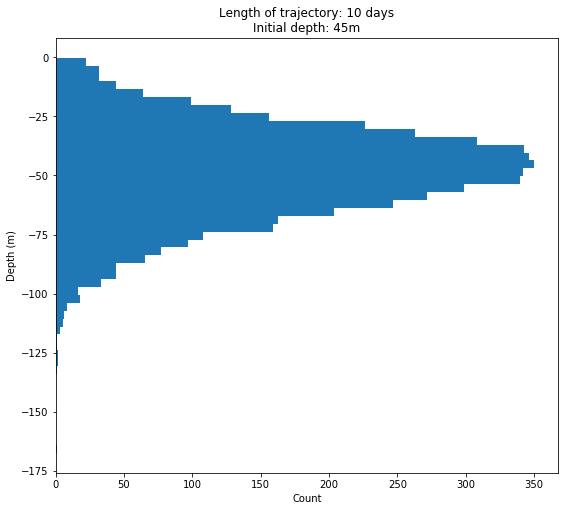

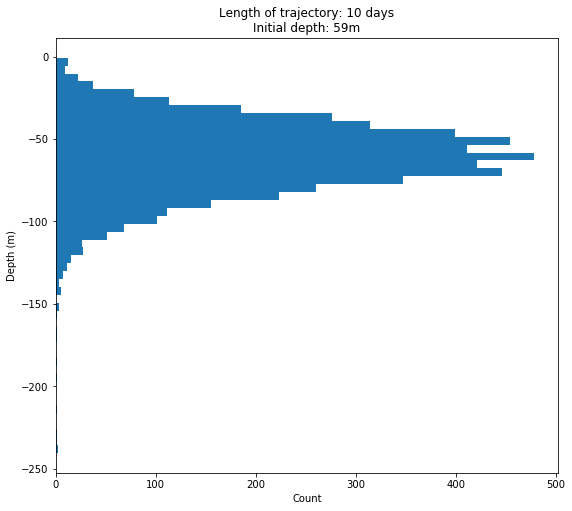

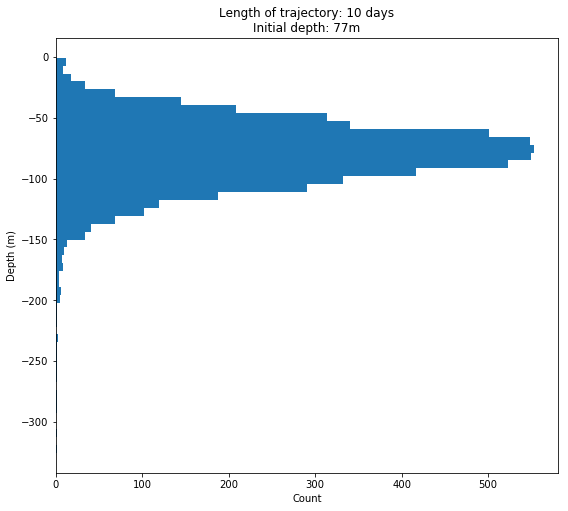

In [10]:
nday = 10

syear = separate(nday)

year1 = syear[0]
year2 = syear[1]
year3 = syear[2]

plot_hist(pts = year1, nday = nday, init_depth = 45)
plot_hist(pts = year2, nday = nday, init_depth = 59)
plot_hist(pts = year3, nday = nday, init_depth = 77)

In [12]:
nday = 20

syear = separate(nday)

start 20160101_20160131_427d:  2017-04-21 16:15:58.376980
time:  0:03:39.347261
start 20160201_20160229_401d:  2017-04-21 16:19:37.725234
time:  0:03:29.511678
start 20160301_20160331_355d:  2017-04-21 16:23:07.238236
time:  0:03:37.124985
start 20160401_20160430_325d:  2017-04-21 16:26:44.364687
time:  0:02:57.495741
start 20160501_20160531_294d:  2017-04-21 16:29:41.861843
time:  0:02:40.744425
start 20160601_20160630_264d:  2017-04-21 16:32:22.607421
time:  0:02:21.372777
start 20160701_20160731_252d:  2017-04-21 16:34:43.981376
time:  0:02:15.527306
start 20160801_20160831_217d:  2017-04-21 16:36:59.509649
time:  0:01:52.118075
start 20160901_20160930_172d:  2017-04-21 16:38:51.629097
time:  0:01:26.050344
start 20161001_20161031_141d:  2017-04-21 16:40:17.680532
time:  0:01:28.661319
start 20161101_20161130_111d:  2017-04-21 16:41:46.343060
time:  0:01:07.037719
start 20161201_20161231_95d:  2017-04-21 16:42:53.381936
time:  0:00:54.231783


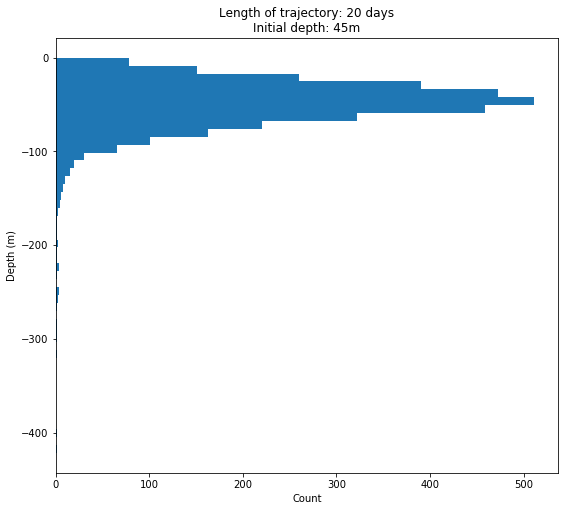

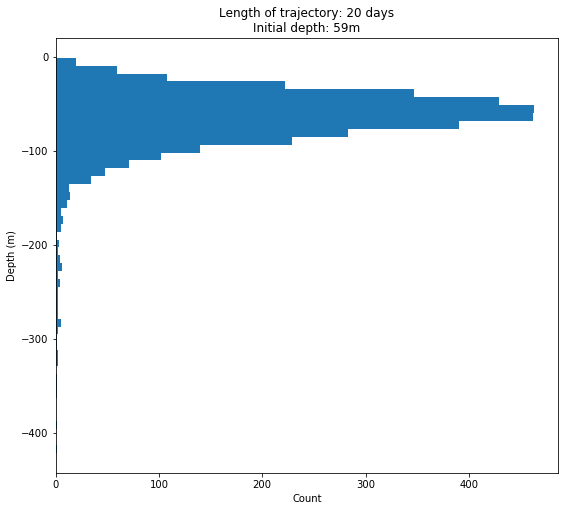

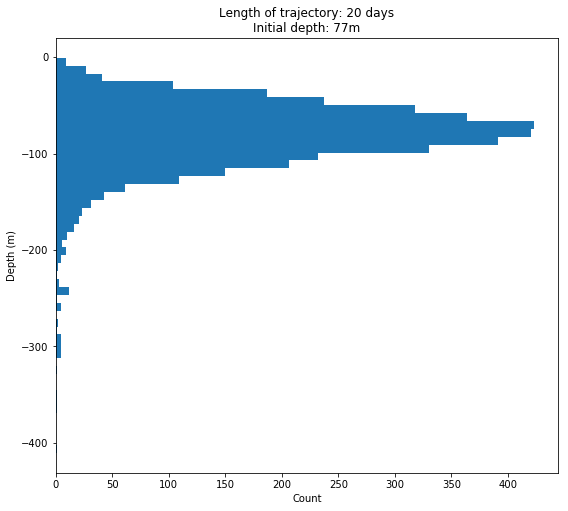

In [13]:
year1 = syear[0]
year2 = syear[1]
year3 = syear[2]

plot_hist(pts = year1, nday = nday, init_depth = 45)
plot_hist(pts = year2, nday = nday, init_depth = 59)
plot_hist(pts = year3, nday = nday, init_depth = 77)

In [18]:
nday = 30

syear = separate(nday)



start 20160101_20160131_427d:  2017-04-21 16:54:04.184753
time:  0:03:46.271753
start 20160201_20160229_401d:  2017-04-21 16:57:50.457489
time:  0:03:31.792839
start 20160301_20160331_355d:  2017-04-21 17:01:22.251309
time:  0:03:06.156486
start 20160401_20160430_325d:  2017-04-21 17:04:28.408865
time:  0:02:54.466362
start 20160501_20160531_294d:  2017-04-21 17:07:22.876654
time:  0:02:55.559992
start 20160601_20160630_264d:  2017-04-21 17:10:18.437811
time:  0:02:16.147899
start 20160701_20160731_252d:  2017-04-21 17:12:34.587107
time:  0:02:11.723564
start 20160801_20160831_217d:  2017-04-21 17:14:46.311838
time:  0:01:52.505723
start 20160901_20160930_172d:  2017-04-21 17:16:38.819165
time:  0:01:25.015953
start 20161001_20161031_141d:  2017-04-21 17:18:03.836209
time:  0:01:12.503795
start 20161101_20161130_111d:  2017-04-21 17:19:16.341441
time:  0:00:55.330200
start 20161201_20161231_95d:  2017-04-21 17:20:11.673004
time:  0:00:48.505566


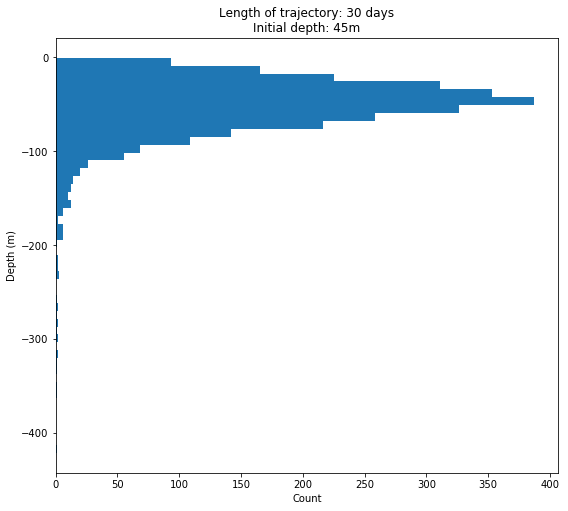

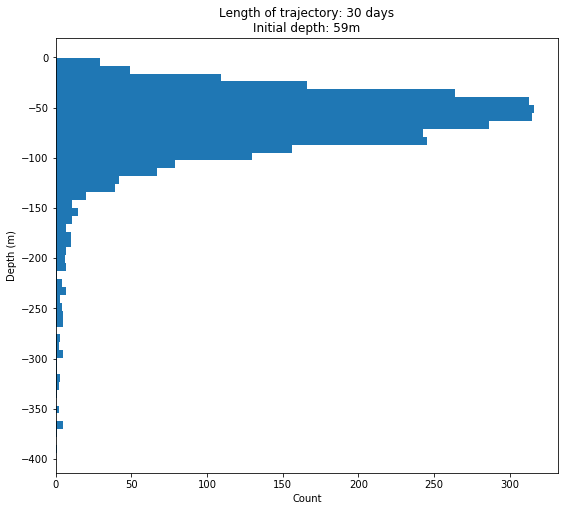

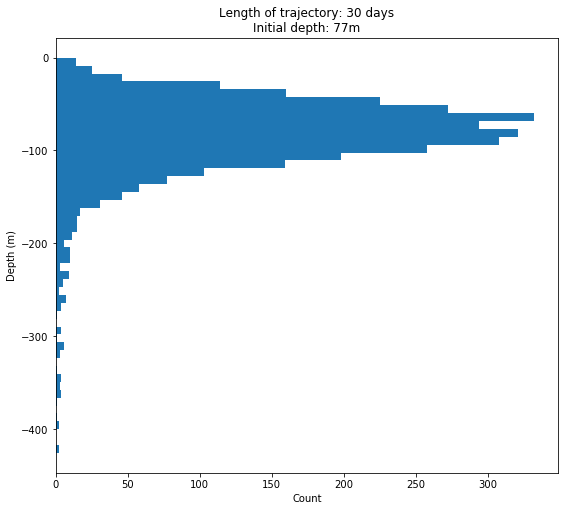

In [19]:
year1 = syear[0]
year2 = syear[1]
year3 = syear[2]

plot_hist(pts = year1, nday = nday, init_depth = 45)
plot_hist(pts = year2, nday = nday, init_depth = 59)
plot_hist(pts = year3, nday = nday, init_depth = 77)

In [20]:
print (len(year1), len(year2), len(year3))

8496 8496 8495


In [21]:
nday = 40

syear = separate(nday)

start 20160101_20160131_427d:  2017-04-21 17:21:01.235633
time:  0:03:38.299122
start 20160201_20160229_401d:  2017-04-21 17:24:39.781951
time:  0:03:18.105931
start 20160301_20160331_355d:  2017-04-21 17:27:57.888906
time:  0:02:55.445124
start 20160401_20160430_325d:  2017-04-21 17:30:53.334767
time:  0:02:36.333183
start 20160501_20160531_294d:  2017-04-21 17:33:29.668946
time:  0:02:23.801446
start 20160601_20160630_264d:  2017-04-21 17:35:53.471413
time:  0:02:05.036151
start 20160701_20160731_252d:  2017-04-21 17:37:58.508526
time:  0:02:03.243252
start 20160801_20160831_217d:  2017-04-21 17:40:01.752587
time:  0:01:46.019475
start 20160901_20160930_172d:  2017-04-21 17:41:47.772919
time:  0:01:20.904346
start 20161001_20161031_141d:  2017-04-21 17:43:08.678154
time:  0:01:09.105226
start 20161101_20161130_111d:  2017-04-21 17:44:17.784396
time:  0:00:52.997089
start 20161201_20161231_95d:  2017-04-21 17:45:10.782403
time:  0:00:47.101570


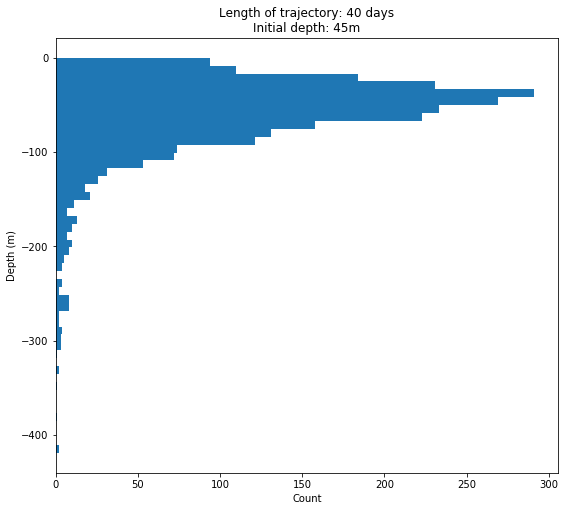

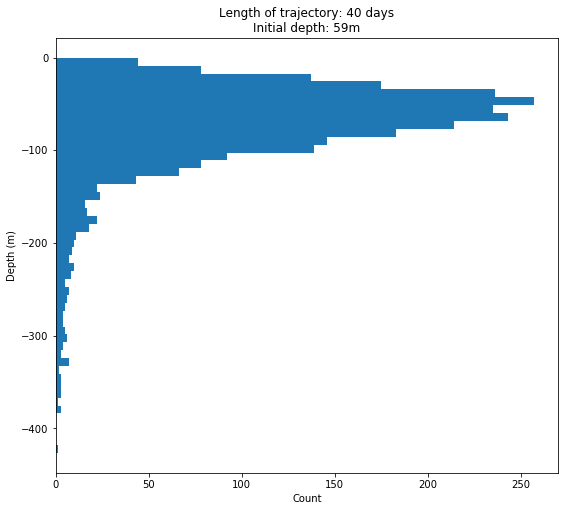

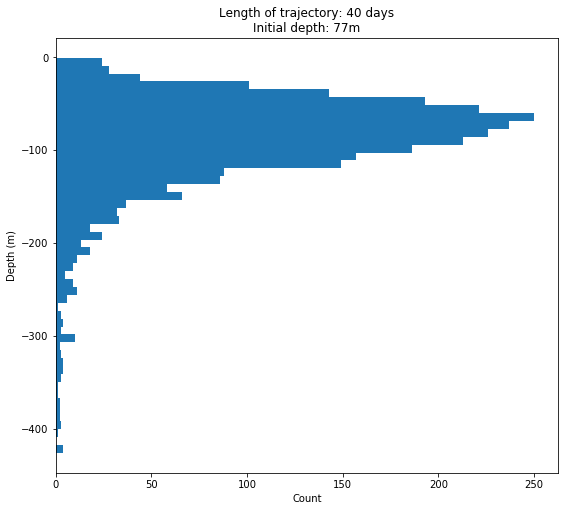

In [22]:
year1 = syear[0]
year2 = syear[1]
year3 = syear[2]

plot_hist(pts = year1, nday = nday, init_depth = 45)
plot_hist(pts = year2, nday = nday, init_depth = 59)
plot_hist(pts = year3, nday = nday, init_depth = 77)

In [23]:
print (len(year1), len(year2), len(year3))

8496 8496 8495


In [24]:
nday = 50

syear = separate(nday)

start 20160101_20160131_427d:  2017-04-21 17:45:58.885588
time:  0:03:35.446381
start 20160201_20160229_401d:  2017-04-21 17:49:34.332931
time:  0:03:09.403787
start 20160301_20160331_355d:  2017-04-21 17:52:43.737550
time:  0:03:00.845272
start 20160401_20160430_325d:  2017-04-21 17:55:44.583709
time:  0:02:39.647991
start 20160501_20160531_294d:  2017-04-21 17:58:24.232517
time:  0:02:28.672255
start 20160601_20160630_264d:  2017-04-21 18:00:52.905741
time:  0:02:10.370955
start 20160701_20160731_252d:  2017-04-21 18:03:03.277675
time:  0:02:08.652326
start 20160801_20160831_217d:  2017-04-21 18:05:11.931008
time:  0:01:51.191361
start 20160901_20160930_172d:  2017-04-21 18:07:03.123345
time:  0:01:23.324006
start 20161001_20161031_141d:  2017-04-21 18:08:26.448324
time:  0:01:10.881520
start 20161101_20161130_111d:  2017-04-21 18:09:37.330670
time:  0:00:54.663248
start 20161201_20161231_95d:  2017-04-21 18:10:31.994836
time:  0:00:48.265884


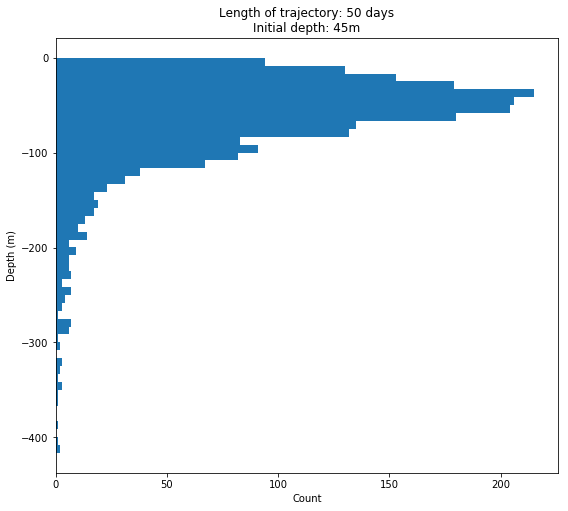

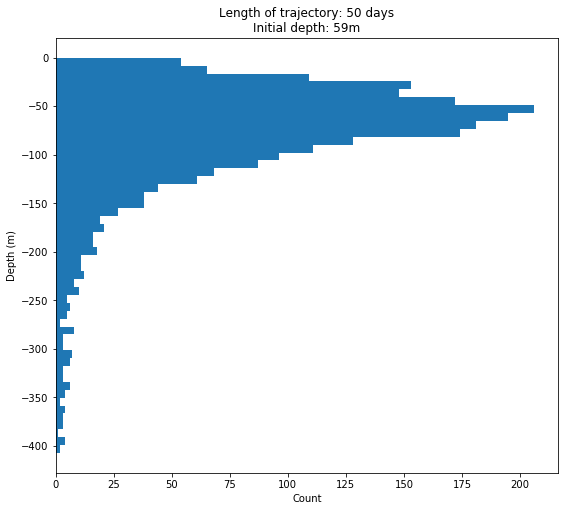

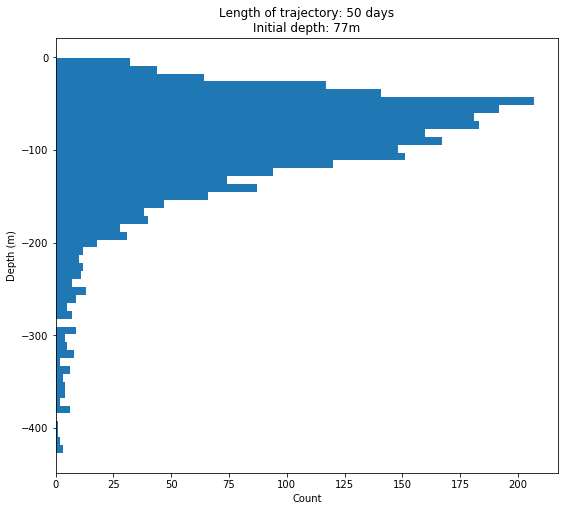

In [25]:
year1 = syear[0]
year2 = syear[1]
year3 = syear[2]

plot_hist(pts = year1, nday = nday, init_depth = 45)
plot_hist(pts = year2, nday = nday, init_depth = 59)
plot_hist(pts = year3, nday = nday, init_depth = 77)

In [27]:
nday = 100

# ###uncomment for test: 
# dirs = dirs [0:3]

syear = separate(nday)

year1 = syear[0]
year2 = syear[1]
year3 = syear[2]

start 20160101_20160131_427d:  2017-05-30 11:53:34.516533
time:  0:03:11.043395
start 20160201_20160229_401d:  2017-05-30 11:56:45.561062
time:  0:03:27.746978
start 20160301_20160331_355d:  2017-05-30 12:00:13.309149
time:  0:03:20.625493


start
1


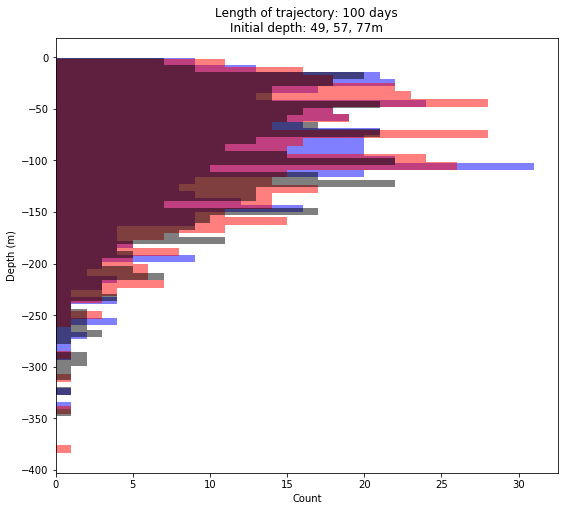

In [91]:
plt.clf()

print ('start')



print ('1')


plot_hist_together(pts1 = year1, pts2 = year2, pts3 = year3, nday = 100, init_depth = "49, 57, 77")

In [ ]:
plt.show()

In [68]:
# Get points for the year - this process should take about 42min for 12 months (3.5min per month)

path = "/ocean/gsgarbi/analysis-giorgio/time_series/results2016/"

dirs = os.listdir( path )

dirs.sort()

dirs = dirs [0:12]

###uncomment for test: 
# dirs = dirs [0:2]

print (dirs)


['20160101_20160131_427d', '20160201_20160229_401d', '20160301_20160331_355d', '20160401_20160430_325d', '20160501_20160531_294d', '20160601_20160630_264d', '20160701_20160731_252d', '20160801_20160831_217d', '20160901_20160930_172d', '20161001_20161031_141d', '20161101_20161130_111d', '20161201_20161231_95d']


<b>5 days<b>

In [69]:
nday = 5

dirs = dirs [0:12]

###uncomment for test: 
# dirs = dirs [0:2]

syear = separate(nday)

perm5 = syear

year1 = syear[0]
year2 = syear[1]
year3 = syear[2]

20160101_20160131_427d
start 20160101_20160131_427d:  2017-06-01 13:25:33.984783
time:  0:03:34.210810
20160201_20160229_401d
start 20160201_20160229_401d:  2017-06-01 13:29:08.214178
time:  0:03:08.781405
20160301_20160331_355d
start 20160301_20160331_355d:  2017-06-01 13:32:17.008251
time:  0:03:04.750710
20160401_20160430_325d
start 20160401_20160430_325d:  2017-06-01 13:35:21.760022
time:  0:02:36.067953
20160501_20160531_294d
start 20160501_20160531_294d:  2017-06-01 13:37:57.829112
time:  0:02:32.470024
20160601_20160630_264d
start 20160601_20160630_264d:  2017-06-01 13:40:30.300054
time:  0:02:06.662225
20160701_20160731_252d
start 20160701_20160731_252d:  2017-06-01 13:42:36.963193
time:  0:02:11.843945
20160801_20160831_217d
start 20160801_20160831_217d:  2017-06-01 13:44:48.807934
time:  0:01:53.188089
20160901_20160930_172d
start 20160901_20160930_172d:  2017-06-01 13:46:41.997029
time:  0:01:22.447948
20161001_20161031_141d
start 20161001_20161031_141d:  2017-06-01 13:48:04

In [70]:
init_depth = "45, 59, 77"

start
check1
8496
(6525,)
check2
check1
8496
(6789,)
check2
check1
8496
(7141,)
check2
(7141, 3)
check3


/ocean/gsgarbi/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/ocean/gsgarbi/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


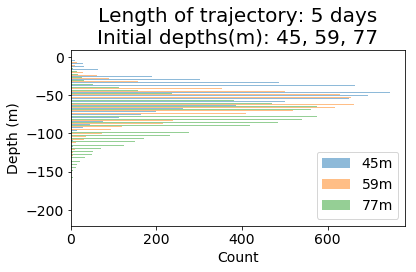

In [71]:
alt_plot(pts1 = year1, pts2 = year2, pts3 = year3, nday = nday, init_depth = init_depth)

<b>50 days</b>

In [72]:
nday = 50

syear = separate(nday)

perm50 = syear

year1 = syear[0]
year2 = syear[1]
year3 = syear[2]

20160101_20160131_427d
start 20160101_20160131_427d:  2017-06-01 13:51:05.961329
time:  0:03:33.309027
20160201_20160229_401d
start 20160201_20160229_401d:  2017-06-01 13:54:39.271315
time:  0:03:06.190525
20160301_20160331_355d
start 20160301_20160331_355d:  2017-06-01 13:57:45.462759
time:  0:02:56.682208
20160401_20160430_325d
start 20160401_20160430_325d:  2017-06-01 14:00:42.146232
time:  0:02:37.000583
20160501_20160531_294d
start 20160501_20160531_294d:  2017-06-01 14:03:19.147965
time:  0:02:25.767033
20160601_20160630_264d
start 20160601_20160630_264d:  2017-06-01 14:05:44.916257
time:  0:02:06.769747
20160701_20160731_252d
start 20160701_20160731_252d:  2017-06-01 14:07:51.686842
time:  0:02:04.681853
20160801_20160831_217d
start 20160801_20160831_217d:  2017-06-01 14:09:56.369496
time:  0:01:48.226788
20160901_20160930_172d
start 20160901_20160930_172d:  2017-06-01 14:11:44.597178
time:  0:01:23.053259
20161001_20161031_141d
start 20161001_20161031_141d:  2017-06-01 14:13:07

start
check1
8496
(2216,)
check2
check1
8496
(2377,)
check2
check1
8495
(2576,)
check2
(2576, 3)
check3


/ocean/gsgarbi/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/ocean/gsgarbi/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


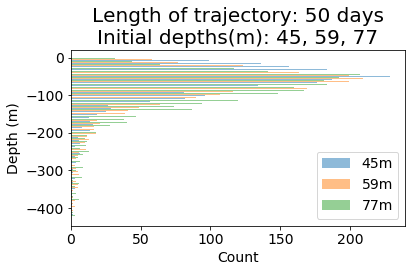

In [73]:
alt_plot(pts1 = year1, pts2 = year2, pts3 = year3, nday = nday, init_depth = init_depth)

<b> 100 days </b>

In [74]:
nday = 100

# ###uncomment for test: 
# dirs = dirs [0:3]

syear = separate(nday)

perm100 = syear

year1 = syear[0]
year2 = syear[1]
year3 = syear[2]

20160101_20160131_427d
start 20160101_20160131_427d:  2017-06-01 14:15:59.943888
time:  0:03:31.745133
20160201_20160229_401d
start 20160201_20160229_401d:  2017-06-01 14:19:31.690170
time:  0:03:04.732882
20160301_20160331_355d
start 20160301_20160331_355d:  2017-06-01 14:22:36.423921
time:  0:02:57.352680
20160401_20160430_325d
start 20160401_20160430_325d:  2017-06-01 14:25:33.777695
time:  0:02:35.242179
20160501_20160531_294d
start 20160501_20160531_294d:  2017-06-01 14:28:09.020883
time:  0:02:49.894741
20160601_20160630_264d
start 20160601_20160630_264d:  2017-06-01 14:30:58.916618
time:  0:02:17.406211
20160701_20160731_252d
start 20160701_20160731_252d:  2017-06-01 14:33:16.323866
time:  0:02:04.139625
20160801_20160831_217d
start 20160801_20160831_217d:  2017-06-01 14:35:20.464477
time:  0:01:46.817120
20160901_20160930_172d
start 20160901_20160930_172d:  2017-06-01 14:37:07.282519
time:  0:01:22.428197
20161001_20161031_141d
start 20161001_20161031_141d:  2017-06-01 14:38:29

start
check1
7776
(1587,)
check2
check1
7776
(1686,)
check2
check1
7774
(1784,)
check2
(1784, 3)


/ocean/gsgarbi/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/ocean/gsgarbi/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


check3


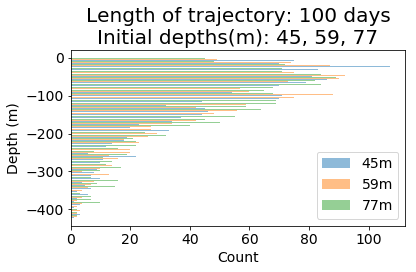

In [77]:
print (dirs)

['20160101_20160131_427d', '20160201_20160229_401d', '20160301_20160331_355d', '20160401_20160430_325d', '20160501_20160531_294d', '20160601_20160630_264d', '20160701_20160731_252d', '20160801_20160831_217d', '20160901_20160930_172d', '20161001_20161031_141d', '20161101_20161130_111d', '20161201_20161231_95d']


In [69]:
nday = 10



###uncomment for test: 
# dirs = dirs [0:2]

syear = separate(nday)

perm5 = syear

year1 = syear[0]
year2 = syear[1]
year3 = syear[2]

FileNotFoundError: [Errno 2] No such file or directory: '/ocean/gsgarbi/selected_days/20160101_20160131_100d.npy_10d.npy'